## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):    
    """
    Build your own model
    """
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [3]:
## 超參數設定
"""
Set your hyper-parameters
"""
epochs = 50
batch_size = 256
patience = [2, 5, 8]
factor = [0.2, 0.5, 0.8]

In [4]:
results = {}
# 載入 Callbacks
"""
Write your training loop and show the results
"""
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
for pat in patience:
    for fac in factor:
        reduce_lr = ReduceLROnPlateau(factor=fac, min_lr=1e-12, monitor='val_loss', patience=pat, verbose=1)
        
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f'patience = {pat}, factor = {fac}')
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=0.01, nesterov=True, momentum=0.95)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
 
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, 
                  callbacks=[earlystop, reduce_lr])

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        name_tag = f'patience = {pat}, factor = {fac}'
        results[name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 
                             'train-acc': train_acc, 'valid-acc': valid_acc}

patience = 2, factor = 0.2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (No

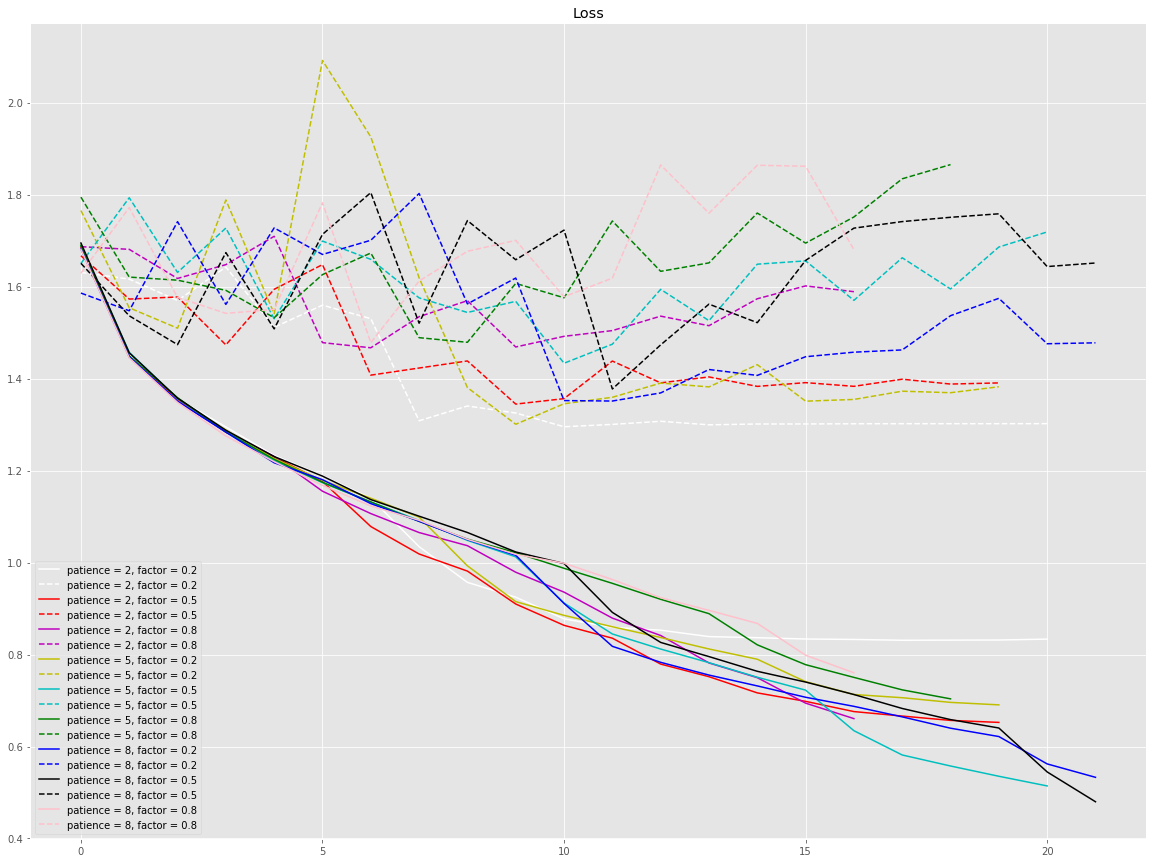

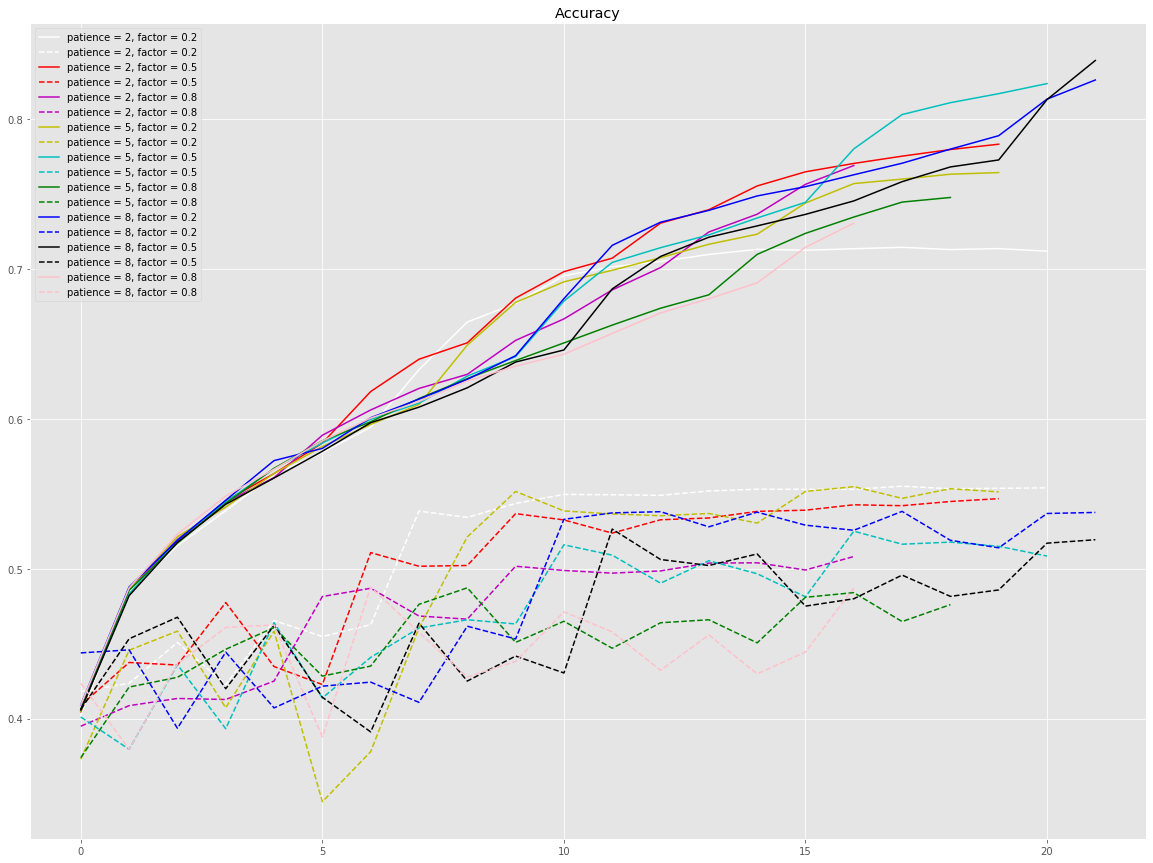

In [5]:

# 繪製結果
"""
plot the results
"""
plt.style.use('ggplot')
color_bar = ['w', 'r', 'm', 'y', 'c', 'g', 'b', 'k', 'pink', 'orange', 'purple', 'gray']

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()